## Importing nice fonts

In [1]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

print("Hello there, and welcome to the Jupyter notebook that will hopefully refine M31's proper motion")

Hello there, and welcome to the Jupyter notebook that will hopefully refine M31's proper motion


## Determination of the transverse velocity

In [71]:
RadDist = 780*3.08E16 #1kpc is 3.086E16km
Angle   = 100*4.84814E-12 #Angle in radian, 20.9 is in µas/yr
YrToSec = 365.25*86400 #Years to seconds

v = RadDist*Angle/YrToSec
print("The transverse velocity of such uncertainties would be about::", v)

The transverse velocity of such uncertainties would be about:: 369.07659441782647


In [61]:
RadDist = 780*3.08E16 #1kpc is 3.086E16km
Angle   = 60*4.84814E-12 #Angle in radian
YrToSec = 365.25*86400 #Years to seconds

qfd = (300*YrToSec)/(RadDist*4.84814E-12)
print("The transverse velocity of such uncertainties would be about::", qfd)

The transverse velocity of such uncertainties would be about:: 81.28394066093884


## First step

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from matplotlib.colors import LogNorm
import pandas as pd
from scipy.stats import gaussian_kde #for the density map
plt.rcParams["font.family"] = "TeX Gyre Schola Math"

In [5]:
def Ellipse(pa):
    theta  = np.linspace(0, 2*np.pi, 333)
    AngDia = 1.8 #degrees, inclination angle
    i      = (90-77.5)*np.pi/180 #radians, inclination angle
    PA     = (90-pa)*np.pi/180 #radians, position angle

    a = AngDia
    b = AngDia

    xpos = a*np.cos(theta) 
    ypos = b*np.sin(theta)*np.sin(i)
    
    return np.cos(PA)*xpos - np.sin(PA)*ypos, np.sin(PA)*xpos + np.cos(PA)*ypos

def CoordinatePlot(Table1, Table2):
    El = Ellipse(37.5) #I can't figure out why this angle isn't working
    PA     = 37.5*np.pi/180
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.9))

    pos = ax1.scatter(Table1['ra'], Table1['dec'], s=0.003, color='orange')
    pos = ax1.plot(El[0], El[1], linestyle='--', color='black')
    ax1.set_title(f'There are {len(Table1)} stars selected', fontname = 'Serif', size = 15)
    ax1.set_xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 15)
    ax1.set_ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 15)
    ax1.xaxis.set_tick_params(labelsize=15)
    ax1.yaxis.set_tick_params(labelsize=15)
    ax1.set_xlim(ax1.get_xlim()[::-1])

    pos = ax2.scatter(Table2['ra'], Table2['dec'], s=0.003, color='orange')
    pos = ax2.plot(El[0], El[1], linestyle='--', color='black')
    ax2.set_title(f'There are {len(Table2)} stars still selected after the cut', fontname = 'Serif', size = 15)
    ax2.set_xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 15)
    ax2.set_ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 15)
    ax2.xaxis.set_tick_params(labelsize=15)
    ax2.yaxis.set_tick_params(labelsize=15)
    ax2.set_xlim(ax2.get_xlim()[::-1])
    
    #plt.savefig('ParaCut.png', dpi=300)   
    plt.show()

Let's first see how looks our table:

In [6]:
hdu_list = fits.open('GaiaData.fits', memmap=True)
hdu_list.info()
evt_data = Table(hdu_list[1].data)
evt_data

Filename: GaiaData.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  votable       1 BinTableHDU    108   204386R x 19C   [K, D, D, D, E, D, E, D, E, E, E, I, E, D, E, D, E, D, E]   


source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,pmra_pmdec_corr,ipd_gof_harmonic_amplitude,ipd_frac_multi_peak,ruwe,phot_g_mean_flux,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_mag
int64,float64,float64,float64,float32,float64,float32,float64,float32,float32,float32,int16,float32,float64,float32,float64,float32,float64,float32
387310087645581056,11.195908490324188,41.89174375779233,nan,nan,nan,nan,nan,nan,nan,0.30882096,0,nan,73.14920630989732,21.026842,20.647360081083384,22.05138,90.49362604242295,19.85635
387309567953910528,11.245222869774707,41.818567129781435,0.8907630692289483,0.58344924,-3.0970327940489235,0.5727365,-1.2641364963896011,0.5195106,0.0051834434,0.013652793,0,1.0010515,158.9252870372801,20.184385,76.34656847188988,20.631569,117.70131935708784,19.570942
387309567953910656,11.237132844560708,41.81968683047942,0.17279213310353628,0.10463137,12.665566902280798,0.100102685,11.119189525181948,0.07904607,-0.031443816,0.021698996,0,0.9772757,1541.279650674568,17.717663,768.8562324355515,18.12393,1109.6656548587068,17.134914
387309567953911680,11.234689551124784,41.83284900867523,nan,nan,nan,nan,nan,nan,nan,0.18322347,0,nan,43.42314676028226,21.593063,66.53877210036755,20.780855,344.47228118089276,18.40501
387309572249452416,11.243528591921079,41.81574191864432,2.555638152990283,0.8922756,0.13713380674519016,0.8678955,-2.9037333621545196,0.78309435,-0.21096788,0.0514042,0,1.2234511,129.66996131993795,20.405268,66.59883278930724,20.779875,157.68421849560573,19.253426
387309572249480448,11.240556125387931,41.82812986135656,nan,nan,nan,nan,nan,nan,nan,0.15861602,0,nan,69.9148107270031,21.075943,26.09956910525949,21.796959,107.67479187486616,19.66761
387309572249703808,11.239831298658505,41.818960350116214,-2.060316588502791,1.1957809,0.829692745364545,1.6438189,-2.2549023252037683,1.1735053,-0.33042866,0.068958335,0,0.98634386,92.13685013554912,20.776283,81.33575973409584,20.562838,66.6003859755353,20.189203
387309572251335552,11.244594214608485,41.814129061661866,-2.2150317600795586,1.6638888,1.25560853175819,2.0255795,-2.152162383839912,1.4649892,-0.07810183,0.05851191,0,1.1034251,93.35399911352724,20.762035,32.50990152588097,21.558502,165.8405261540916,19.19867
387309602313648128,11.250523699523848,41.82522444574536,2.697784947992454,0.0139588555,7.930499906269666,0.013515746,-9.160462188974286,0.010322429,0.013671579,0.031577844,0,1.0172473,215547.35353529075,12.35351,117516.7713633668,12.663293,139957.79654617983,11.882903


## Dealing with the spherical projected onto a 2D plane and hence converting the proper motions of the stars from Gaia from ($\alpha, \delta$) to ($\xi, \eta$)

Indeed, all the proper motions from Gaia, as the positions are given in $\alpha, \delta$ coordinates, however our model is based on $\xi, \eta$, so we will convert all these quantities. They are only changing along the $\alpha$ axis by a constant being $\times \cos(\delta)$ where $\delta$ is the declination being 41.27° at the position of M31.

In [7]:
Delta = 41.27*np.pi/180

evt_data['ra']  = (evt_data['ra'] - 10.68)*np.cos(Delta)
evt_data['dec'] = (evt_data['dec'] - 41.27)

#evt_data['pmra']        = evt_data['pmra']*np.cos(Delta)
#evt_data['pmra_error']  = evt_data['pmra_error']*np.cos(Delta)

## Removing the null values

In [8]:
mask0 = (np.isnan(evt_data['parallax']) != True)

## One sigma confidence interval for parallax
We firstly suppress all the stars of the foreground within a distance 10kpc. To do so we simply apply: $\varpi - \sigma_{\varpi} < 0.1$.

/usr/lib/python3/dist-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


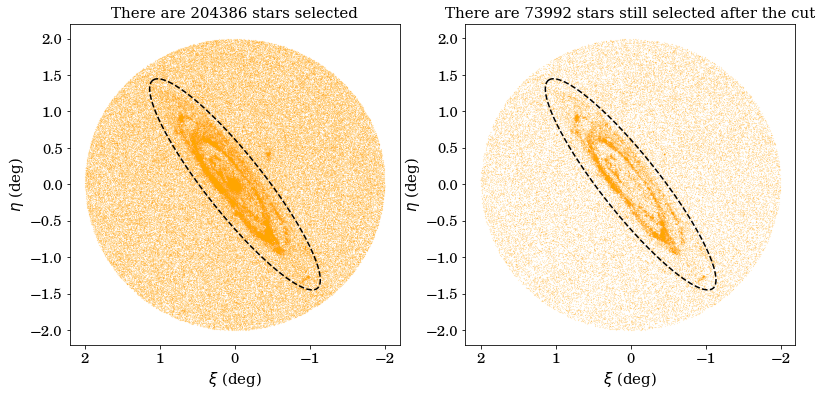

In [9]:
mask1 = (np.isnan(evt_data['parallax']) != True) & ((evt_data['parallax'] - evt_data['parallax_error']) < 0.1) #10kpc but the parallax is in mas
CoordinatePlot(evt_data, evt_data[mask1])

We can quickly visually check that with:

In [10]:
abs(1/(evt_data[mask1]['parallax']/1000))[0:5]

5787.300509802749
485.3623009106036
451.4607952908461
3630.0671491679977
1183.3524307517587


## Conservative restrictions inf the colour magnitude diagram
We need the G magnitude and also the G$_{\textrm{BP}}$ and the G$_{\textrm{RP}}$. 

/usr/lib/python3/dist-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


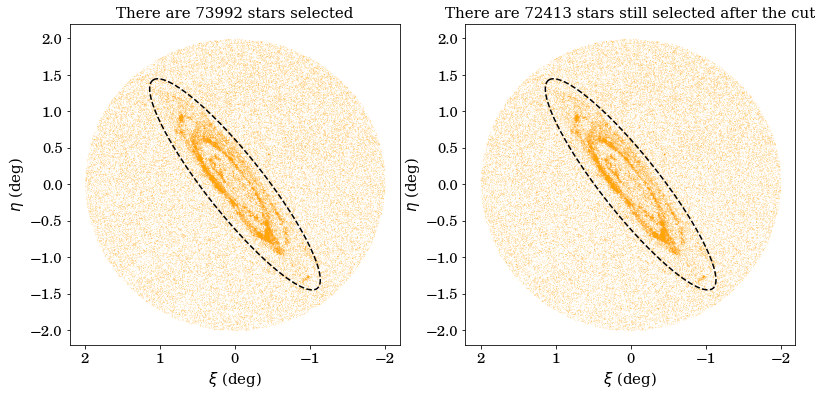

In [11]:
mask2 = (np.isnan(evt_data['parallax']) != True) & ((evt_data['parallax'] - evt_data['parallax_error']) < 0.1
        ) & (evt_data['phot_g_mean_mag'] > 16) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']
        ) < 4) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) > -1)
CoordinatePlot(evt_data[mask1], evt_data[mask2])

We can note that this value is the same found in the article. 

## Excess flux
We will firstly create our $f(x)$ function based on the table 2 of the article of M.Riello from 2021. We also define a function which role is to determine if the condition (1), from the Salomon article is respected or not (CCorrCond). To do so we also have to determine the $C_{\textrm{corr}}$ first.

In [12]:
def f(x): #x simply is GBP - GRP
    if np.isnan(x) == True:
        return 0 #The value won't be kept anyway because of the nan condition
    if x < 0.5:
        return (1.154360 + 0.033772*x + 0.032277*x*x)
    if x >= 0.5 and x < 4.0:
        return (1.162004 + 0.011464*x + 0.049255*x*x - 0.005879*x*x*x)
    if x >= 4.0:
        return (1.057572 + 0.140537*x)

def CCorrCond(ibp, irp, ig, x, g): #the I are the fluxes in the different bands and x = GBP - GRP
    Result  = []
    CorList = []
    IBP, IRP, IG, X, G = np.array(ibp), np.array(irp), np.array(ig), np.array(x), np.array(g)
    for i in range(len(IBP)):
        CCorr = (IBP[i] + IRP[i])/IG[i] - f(X[i])
        CorList.append(abs(CCorr))
        if abs(CCorr) > 3*(5.9898E-3 + 8.817481E-12 * G[i]**(7.618399)):
            Result.append(True)
        else: 
            Result.append(False)
    return Result, CorList

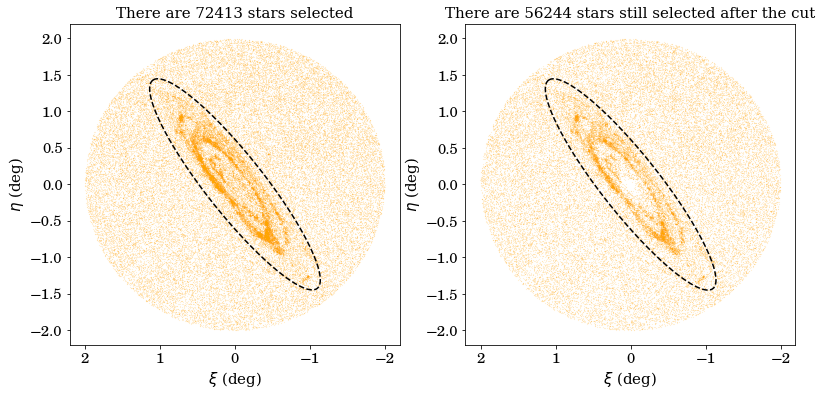

In [13]:
mask3 = (np.isnan(evt_data['parallax']) != True
       ) & ((evt_data['parallax'] - evt_data['parallax_error']) < 0.1
       ) & (evt_data['phot_g_mean_mag'] > 16
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) < 4
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) > -1
       ) & (np.array(CCorrCond(evt_data['phot_bp_mean_flux'], evt_data['phot_rp_mean_flux'], 
                               evt_data['phot_g_mean_flux'], (evt_data['phot_bp_mean_mag'] - 
                               evt_data['phot_rp_mean_mag']), evt_data['phot_g_mean_mag'])[0]) == False)
CoordinatePlot(evt_data[mask2], evt_data[mask3])

## Verification of corrected excess factor faithfulness

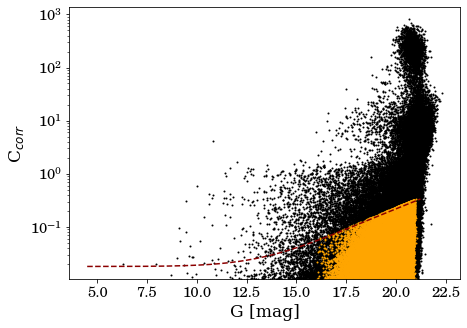

In [14]:
Mask = mask3 #easily changable variable
MasK = mask1

#Let's first plot the theoritical bottom limit for the CCorr as described in the article from Salomon
XG    = np.linspace(min(np.array(evt_data['phot_g_mean_mag'])), max(np.array(evt_data[mask2]['phot_g_mean_mag'])), 1000)
YG    = 3*(5.9898E-3 + 8.17481E-12 * XG**(7.618399))
#We introduce the points which are our initial data
CCorr1 = np.array(CCorrCond(evt_data['phot_bp_mean_flux'], evt_data['phot_rp_mean_flux'], 
                               evt_data['phot_g_mean_flux'], (evt_data['phot_bp_mean_mag'] - 
                               evt_data['phot_rp_mean_mag']), evt_data['phot_g_mean_mag'])[1])

#We introduce the points that are kept after the cut
CCorr2 = np.array(CCorrCond(evt_data[Mask]['phot_bp_mean_flux'], evt_data[Mask]['phot_rp_mean_flux'], 
                               evt_data[Mask]['phot_g_mean_flux'], (evt_data[Mask]['phot_bp_mean_mag'] - 
                               evt_data[Mask]['phot_rp_mean_mag']), evt_data[Mask]['phot_g_mean_mag'])[1])

plt.figure(figsize=(7, 5))
#plt.scatter(evt_data[MasK]['phot_g_mean_mag'], CCorr1, s=1, color='black')
plt.scatter(evt_data['phot_g_mean_mag'], CCorr1, s=1, color='black')
plt.scatter(evt_data[Mask]['phot_g_mean_mag'], CCorr2, s=1, color='orange')
plt.plot(XG, YG, linestyle='--', color='darkred')
#plt.title(f'Verification of the model accuracy', fontname = 'Serif', size = 21)
plt.xlabel('G [mag]', fontname = 'Serif', size = 17)
plt.ylabel('C$_{corr}$', fontname = 'Serif', size = 17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.yscale("log")
#plt.savefig("What?.png")
plt.show()

In [15]:
choice1 = input("Are you sure you want to lauch the program, this might take a while? (Yes/No): ")

if choice1 == "Yes":
    maskDensi = (np.isnan(evt_data['phot_bp_mean_flux']) != True) & (np.isnan(evt_data['phot_rp_mean_flux']) != True
                ) & (np.isnan(evt_data['phot_g_mean_flux']) != True) & (np.isnan(evt_data['phot_bp_mean_mag']) != True
                ) & (np.isnan(evt_data['phot_rp_mean_mag']) != True) & (np.isnan(evt_data['phot_g_mean_mag']) != True
                ) & (np.isnan(evt_data['parallax']) != True) & ((evt_data['parallax'] - evt_data['parallax_error']) < 0.1
            ) & (evt_data['phot_g_mean_mag'] > 16) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']
            ) < 4) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) > -1)

    CCorr1 = np.array(CCorrCond(evt_data[maskDensi]['phot_bp_mean_flux'], evt_data[maskDensi]['phot_rp_mean_flux'], 
                                   evt_data[maskDensi]['phot_g_mean_flux'], (evt_data[maskDensi]['phot_bp_mean_mag'] - 
                                   evt_data[maskDensi]['phot_rp_mean_mag']), evt_data[maskDensi]['phot_g_mean_mag'])[1])

    x = []
    y = []

    for i in range(len(CCorr1)):
        x.append(evt_data[maskDensi]['phot_g_mean_mag'][i])
        y.append(CCorr1[i])

    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

Are you sure you want to lauch the program, this might take a while? (Yes/No): No


In [16]:
if choice1 == "Yes":
    plt.scatter(x, y, c=z, s=1, cmap='inferno')
    plt.plot(XG, YG, linestyle='--', color='darkred')
    plt.xlabel('G [mag]', fontname = 'Serif', size = 17)
    plt.ylabel('C$_{corr}$', fontname = 'Serif', size = 17)
    #plt.colorbar(label='Density', orientation='vertical')
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.yscale("log")
    plt.savefig('myfigure_1000.png', dpi=500)
    plt.show()

## Resolved and non-binary sources
We have three simple cuts to apply, so pretty straight foward.

In [17]:
mask4 = (np.isnan(evt_data['parallax']) != True
       ) & ((evt_data['parallax'] - evt_data['parallax_error']) < 0.1
       ) & (evt_data['phot_g_mean_mag'] > 16
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) < 4
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) > -1
       ) & (np.array(CCorrCond(evt_data['phot_bp_mean_flux'], evt_data['phot_rp_mean_flux'], 
                               evt_data['phot_g_mean_flux'], (evt_data['phot_bp_mean_mag'] - 
                               evt_data['phot_rp_mean_mag']), evt_data['phot_g_mean_mag'])[0]) == False
       ) & (evt_data['ruwe'] < 1.3
       ) & (evt_data['ipd_gof_harmonic_amplitude'] < 0.1
       ) & (evt_data['ipd_frac_multi_peak'] < 2)
#CoordinatePlot(evt_data[mask2], evt_data[mask4])

## Spatial selection

### Only with the ellipse

In [18]:
def ElContour(RA, DEC):
    Ra, Dec = np.array(RA), np.array(DEC)
    Result = []
    
    AngDia = 1.8 #degrees, inclination angle
    i      = (90-77.5)*np.pi/180 #radians, inclination angle
    PA     = 37.5*np.pi/180 #radians, position angle
    
    B = AngDia
    A = AngDia*np.sin(i)
    
    R_rot = np.array([[np.cos(PA), -np.sin(PA)], [np.sin(PA), np.cos(PA)]])
    
    for i in range(len(Ra)):
        Ell_rot = np.dot(R_rot, [Ra[i], Dec[i]])
        if (Ell_rot[0]**2)/(A**2) + (Ell_rot[1]**2)/(B**2) <= 1:
            Result.append(True)
        else: 
            Result.append(False)

    return Result

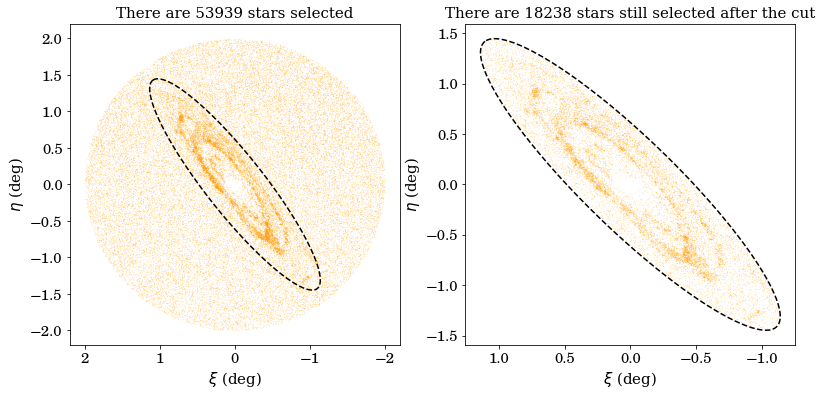

In [19]:
mask5 = (np.isnan(evt_data['parallax']) != True
       ) & ((evt_data['parallax'] - evt_data['parallax_error']) < 0.1
       ) & (evt_data['phot_g_mean_mag'] > 16
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) < 4
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) > -1
       ) & (np.array(CCorrCond(evt_data['phot_bp_mean_flux'], evt_data['phot_rp_mean_flux'], 
                               evt_data['phot_g_mean_flux'], (evt_data['phot_bp_mean_mag'] - 
                               evt_data['phot_rp_mean_mag']), evt_data['phot_g_mean_mag'])[0]) == False
       ) & (evt_data['ruwe'] < 1.3
       ) & (evt_data['ipd_gof_harmonic_amplitude'] < 0.1
       ) & (evt_data['ipd_frac_multi_peak'] < 2
       ) & (np.array(ElContour(evt_data['ra'], evt_data['dec'])) == True)
CoordinatePlot(evt_data[mask4], evt_data[mask5])

## Fiducial sample (blue)

In [20]:
mask6 = (np.isnan(evt_data['parallax']) != True
       ) & ((evt_data['parallax'] - evt_data['parallax_error']) < 0.1
       ) & (evt_data['phot_g_mean_mag'] > 16
       ) & (evt_data['phot_g_mean_mag'] < 20
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) < 0.5
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) > -1
       ) & (np.array(CCorrCond(evt_data['phot_bp_mean_flux'], evt_data['phot_rp_mean_flux'], 
                               evt_data['phot_g_mean_flux'], (evt_data['phot_bp_mean_mag'] - 
                               evt_data['phot_rp_mean_mag']), evt_data['phot_g_mean_mag'])[0]) == False
       ) & (evt_data['ruwe'] < 1.3
       ) & (evt_data['ipd_gof_harmonic_amplitude'] < 0.1
       ) & (evt_data['ipd_frac_multi_peak'] < 2
       ) & (np.array(ElContour(evt_data['ra'], evt_data['dec'])) == True)

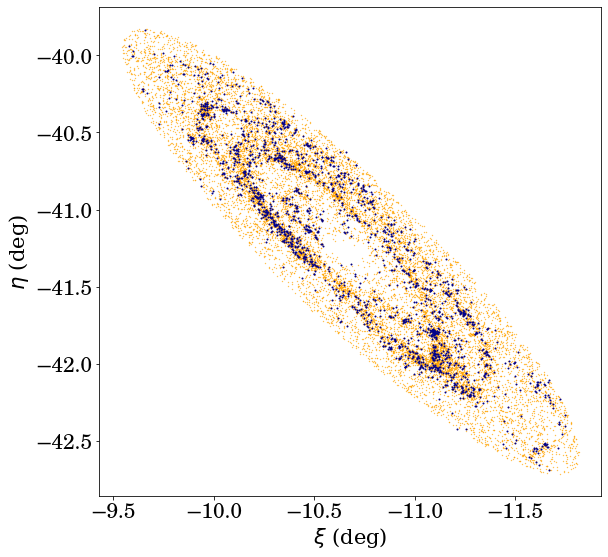

In [21]:
plt.figure(figsize=(9, 9))
plt.scatter(evt_data[mask5]['ra'] - 10.68, evt_data[mask5]['dec'] - 41.27, s=0.1, color='orange')
plt.scatter(evt_data[mask6]['ra'] - 10.68, evt_data[mask6]['dec'] - 41.27, s=0.9, color='darkblue')
#plt.title(f'There are {len(evt_data[mask6])} stars selected', fontname = 'Serif', size = 21)
plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
plt.show()

## Red star sample

In [22]:
def RedTopCut(g, x): #where x is GBP - GRP
    Result = []
    G, X = np.array(g), np.array(x)
    
    for i in range(len(G)):
        if np.isnan(G[i] > -1.4*(X[i]) + 20.65) == True:
            return 0 
        if G[i] > -1.4*(X[i]) + 20.65:
            Result.append(True)
        else: 
            Result.append(False)

    return Result

In [23]:
mask7 = (np.isnan(evt_data['parallax']) != True
       ) & ((evt_data['parallax'] - evt_data['parallax_error']) < 0.1
       ) & (np.array(RedTopCut(evt_data['phot_g_mean_mag'], (evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']))) == True
       ) & (evt_data['phot_g_mean_mag'] < 20
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) < 4
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) > 1.6
       ) & (np.array(CCorrCond(evt_data['phot_bp_mean_flux'], evt_data['phot_rp_mean_flux'], 
                               evt_data['phot_g_mean_flux'], (evt_data['phot_bp_mean_mag'] - 
                               evt_data['phot_rp_mean_mag']), evt_data['phot_g_mean_mag'])[0]) == False
       ) & (evt_data['ruwe'] < 1.3
       ) & (evt_data['ipd_gof_harmonic_amplitude'] < 0.1
       ) & (evt_data['ipd_frac_multi_peak'] < 2
       ) & (np.array(ElContour(evt_data['ra'], evt_data['dec'])) == True)

<ipython-input-22-fcba6570fc92>:6: RuntimeWarning: invalid value encountered in greater
  if np.isnan(G[i] > -1.4*(X[i]) + 20.65) == True:
<ipython-input-22-fcba6570fc92>:8: RuntimeWarning: invalid value encountered in greater
  if G[i] > -1.4*(X[i]) + 20.65:


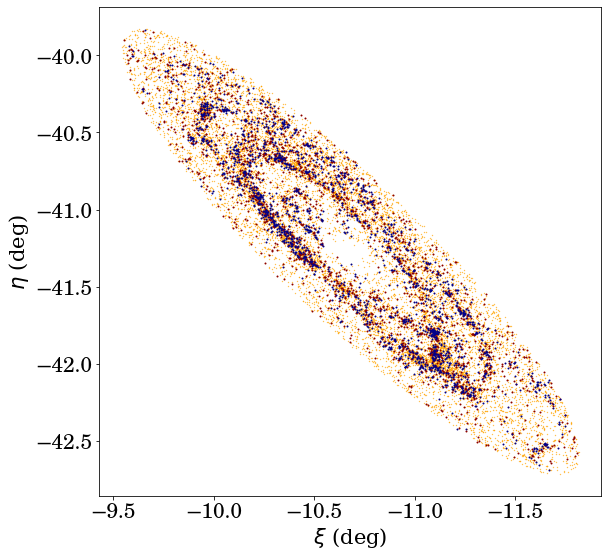

In [24]:
plt.figure(figsize=(9, 9))
plt.scatter(evt_data[mask5]['ra'] - 10.68, evt_data[mask5]['dec'] - 41.27, s=0.1, color='orange')
plt.scatter(evt_data[mask7]['ra'] - 10.68, evt_data[mask7]['dec'] - 41.27, s=0.9, color='darkred')
plt.scatter(evt_data[mask6]['ra'] - 10.68, evt_data[mask6]['dec'] - 41.27, s=0.9, color='darkblue')
plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig("BlueAndRedStars.png")
plt.show()

## Number of blue and red stars

### The blue sample presents

In [25]:
print('We find', len(evt_data[mask6]['ra']), 'stars while in the article they found 1919.')

We find 1922 stars while in the article they found 1919.


### The red sample presents

In [26]:
print('We find', len(evt_data[mask7]['ra']), 'stars while in the article they found 2083.')

We find 2149 stars while in the article they found 2083.


## Colour magnitude diagram

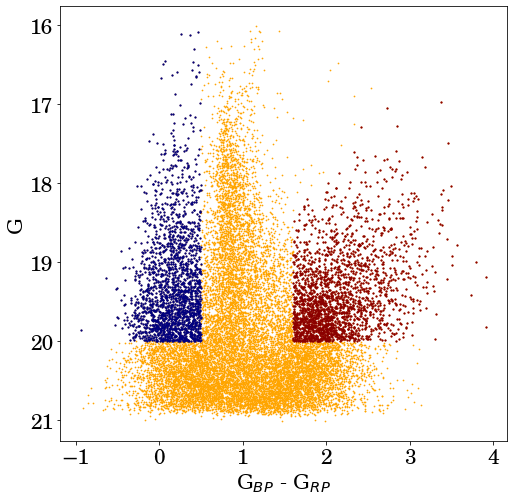

In [27]:
plt.figure(figsize=(8, 8))
plt.scatter((evt_data[mask5]['phot_bp_mean_mag'] - evt_data[mask5]['phot_rp_mean_mag']), evt_data[mask5]['phot_g_mean_mag'], s=0.5, color='orange')
plt.scatter((evt_data[mask7]['phot_bp_mean_mag'] - evt_data[mask7]['phot_rp_mean_mag']), evt_data[mask7]['phot_g_mean_mag'], s=1.5, color='darkred')
plt.scatter((evt_data[mask6]['phot_bp_mean_mag'] - evt_data[mask6]['phot_rp_mean_mag']), evt_data[mask6]['phot_g_mean_mag'], s=1.5, color='navy')
#plt.title('Colour magnitude diagram', fontname = 'Serif', size = 21)
plt.xlabel('G$_{BP}$ - G$_{RP}$', fontname = 'Serif', size = 21)
plt.ylabel('G', fontname = 'Serif', size = 21)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_yaxis()
#plt.savefig("CoulourDiagram.png")
plt.show()

Now we would like to compare this colour diagram with the one without having deleted any of the stars, that is from the initial star sample.

In [28]:
choice2 = input("Are you sure you want to lauch the program, this might take a while? (Yes/No): ")

if choice2 == "Yes":
    """
    maskHR = (np.isnan(evt_data['phot_bp_mean_flux']) != True) & (np.isnan(evt_data['phot_rp_mean_flux']) != True
                ) & (np.isnan(evt_data['phot_g_mean_flux']) != True) & (np.isnan(evt_data['phot_bp_mean_mag']) != True
                ) & (np.isnan(evt_data['phot_rp_mean_mag']) != True) & (np.isnan(evt_data['phot_g_mean_mag']) != True
                ) & (np.isnan(evt_data['parallax']) != True)             
    """

    x = []
    y = []

    for i in range(len(evt_data[mask7]['phot_g_mean_mag'])):
        x.append((evt_data[mask7]['phot_bp_mean_mag'][i] - evt_data[mask7]['phot_rp_mean_mag'][i]))
        y.append(evt_data[mask7]['phot_g_mean_mag'][i])

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

Are you sure you want to lauch the program, this might take a while? (Yes/No): No


In [29]:
if choice2 == "Yes":
    plt.figure(figsize=(8, 8))
    plt.scatter(x, y, c=z, s=1, cmap='inferno')
    plt.xlabel('G [mag]', fontname = 'Serif', size = 17)
    plt.ylabel('C$_{corr}$', fontname = 'Serif', size = 17)
    plt.xlabel('G$_{BP}$ - G$_{RP}$', fontname = 'Serif', size = 21)
    plt.ylabel('G', fontname = 'Serif', size = 21)
    plt.xticks(fontsize = 21)
    plt.yticks(fontsize = 21)
    plt.gca().invert_yaxis()
    #plt.savefig('myfigure_1000.png', dpi=500)
    plt.show()

## Quadrant selection 

In [30]:
def ElContaminant(RA, DEC, Num): 
    Ra, Dec = np.array(RA), np.array(DEC)
    Result = []
    
    Sign = [[1, 1], [1, -1], [-1, 1], [-1, -1]]
    
    i      = (90-77.5)*np.pi/180 #radians, inclination angle
    PA     = 37.5*np.pi/180 #radians, position angle
    
    #Small ellipse::
    AngDia1 = 1.8 #degrees, inclination angle
    b = AngDia1
    a = AngDia1*np.sin(i)

    Area1 = np.pi*a*b
    
    #Big ellipse::
    Area2   = 0 #area of the second larger ellipse
    AngDia2 = 2 #degrees, inclination angle
    
    count = 1    #if odd increase A and if even increase B
    A     = AngDia2*np.sin(i)
    B     = AngDia2
    
    while Area2/4 < Area1:
        A *= 1.01
        Area2 = np.pi*A*B
    
    R_rot = np.array([[np.cos(PA), -np.sin(PA)], [np.sin(PA), np.cos(PA)]])
    
    for i in range(len(Ra)):
        Ell_rot = np.dot(R_rot, [Ra[i], Dec[i]])
        if (Ell_rot[0]**2)/(A**2) + (Ell_rot[1]**2)/(B**2) <= 1: #Keeps every stars in the big ellipse
            if (Ell_rot[0]**2)/(a**2) + (Ell_rot[1]**2)/(b**2) >= 1: #Removes all the stars from the inner ellipse
                if Sign[Num][0]*Ell_rot[0]*np.cos(PA) < 0 and Sign[Num][1]*Ell_rot[1]*np.sin(PA) < 0: #Linear selection along lines
                    Result.append(True)
                else: 
                    Result.append(False)
            else:
                Result.append(False)
        else: 
            Result.append(False)

    return Result

In [31]:
def Quadrant(evt_data, Number):
    mask = (np.isnan(evt_data['parallax']) != True
       ) & ((evt_data['parallax'] - evt_data['parallax_error']) < 0.1
       ) & (evt_data['phot_g_mean_mag'] > 16
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) < 4
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) > -1
       ) & (np.array(CCorrCond(evt_data['phot_bp_mean_flux'], evt_data['phot_rp_mean_flux'], 
                               evt_data['phot_g_mean_flux'], (evt_data['phot_bp_mean_mag'] - 
                               evt_data['phot_rp_mean_mag']), evt_data['phot_g_mean_mag'])[0]) == False
       ) & (evt_data['ruwe'] < 1.3
       ) & (evt_data['ipd_gof_harmonic_amplitude'] < 0.1
       ) & (evt_data['ipd_frac_multi_peak'] < 2
       ) & (np.array(ElContaminant(evt_data['ra'], evt_data['dec'], Number)) == True)
    
    return evt_data[mask]['ra'], evt_data[mask]['dec']

In [32]:
RaDec1 = Quadrant(evt_data, 0)
RaDec2 = Quadrant(evt_data, 1)
RaDec3 = Quadrant(evt_data, 2)
RaDec4 = Quadrant(evt_data, 3)

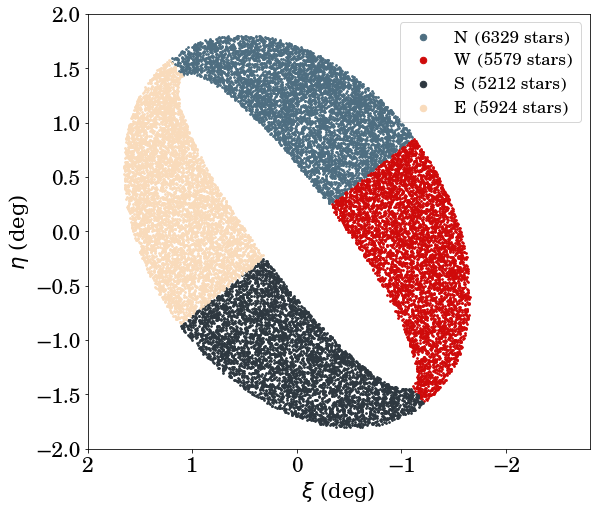

In [33]:
plt.figure(figsize=(9, 8))
plt.scatter((RaDec2[0]), (RaDec2[1]), s=3, color='#4E6E81', label=f"N ({len(RaDec2[0])} stars)")
plt.scatter((RaDec1[0]), (RaDec1[1]), s=3, color='#CF0A0A', label=f"W ({len(RaDec1[0])} stars)")
plt.scatter((RaDec3[0]), (RaDec3[1]), s=3, color='#2E3840', label=f"S ({len(RaDec3[0])} stars)")
plt.scatter((RaDec4[0]), (RaDec4[1]), s=3, color='#F9DBBB', label=f"E ({len(RaDec4[0])} stars)")
plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.xlim(-2.8, 2)
plt.ylim(-2, 2)
plt.gca().invert_xaxis()
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=17)
lgnd.legendHandles[0]._sizes = [42]
lgnd.legendHandles[1]._sizes = [42]
lgnd.legendHandles[2]._sizes = [42]
lgnd.legendHandles[3]._sizes = [42]
plt.show()

## Estimation of the contamination

In [34]:
def QuadrantBlue(evt_data, Number):
    maskB = (np.isnan(evt_data['parallax']) != True
       ) & ((evt_data['parallax'] - evt_data['parallax_error']) < 0.1
       ) & (evt_data['phot_g_mean_mag'] > 16
       ) & (evt_data['phot_g_mean_mag'] < 20
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) < 0.5
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) > -1
       ) & (np.array(CCorrCond(evt_data['phot_bp_mean_flux'], evt_data['phot_rp_mean_flux'], 
                               evt_data['phot_g_mean_flux'], (evt_data['phot_bp_mean_mag'] - 
                               evt_data['phot_rp_mean_mag']), evt_data['phot_g_mean_mag'])[0]) == False
       ) & (evt_data['ruwe'] < 1.3
       ) & (evt_data['ipd_gof_harmonic_amplitude'] < 0.1
       ) & (evt_data['ipd_frac_multi_peak'] < 2
       ) & (np.array(ElContaminant(evt_data['ra'], evt_data['dec'], Number)) == True)
    
    return evt_data[maskB]['ra'], evt_data[maskB]['dec'], evt_data[maskB]['pmra'], evt_data[maskB]['pmdec']

def QuadrantRed(evt_data, Number):
    maskR = (np.isnan(evt_data['parallax']) != True
       ) & ((evt_data['parallax'] - evt_data['parallax_error']) < 0.1
       ) & (np.array(RedTopCut(evt_data['phot_g_mean_mag'], (evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']))) == True
       ) & (evt_data['phot_g_mean_mag'] < 20
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) < 4
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) > 1.6
       ) & (np.array(CCorrCond(evt_data['phot_bp_mean_flux'], evt_data['phot_rp_mean_flux'], 
                               evt_data['phot_g_mean_flux'], (evt_data['phot_bp_mean_mag'] - 
                               evt_data['phot_rp_mean_mag']), evt_data['phot_g_mean_mag'])[0]) == False
       ) & (evt_data['ruwe'] < 1.3
       ) & (evt_data['ipd_gof_harmonic_amplitude'] < 0.1
       ) & (evt_data['ipd_frac_multi_peak'] < 2
       ) & (np.array(ElContaminant(evt_data['ra'], evt_data['dec'], Number)) == True)
    
    return evt_data[maskR]['ra'], evt_data[maskR]['dec'], evt_data[maskR]['pmra'], evt_data[maskR]['pmdec']

def Lines(pa): #Will help us to visualise the quadrants in the following graph, returns four lists
    PA     = pa*np.pi/180
    x = np.linspace(-5, 5, 200)
    
    return x + 10.68, x*np.sin(89*np.pi/180) + 41.27, x + 10.68, -x*np.sin(PA) + 41.27 #The angle for the first y is a bit weird

### Raw estimation without any plot

In [35]:
AllBlueRa  = []
AllBlueDec = []
AllRedRa   = []
AllRedDec  = []

for i in range(4): 
    AllBlueRa.append(np.array(QuadrantBlue(evt_data, i)[0]))
    AllBlueDec.append(np.array(QuadrantBlue(evt_data, i)[1]))
    AllRedRa.append(np.array(QuadrantRed(evt_data, i)[0]))
    AllRedDec.append(np.array(QuadrantRed(evt_data, i)[1])) 

<ipython-input-22-fcba6570fc92>:6: RuntimeWarning: invalid value encountered in greater
  if np.isnan(G[i] > -1.4*(X[i]) + 20.65) == True:
<ipython-input-22-fcba6570fc92>:8: RuntimeWarning: invalid value encountered in greater
  if G[i] > -1.4*(X[i]) + 20.65:


In [36]:
ContaminantsBlue = []

ContaminantsBlue.append(round(len(AllBlueRa[0]) / len(evt_data[mask6]['ra']) *100, 1))
ContaminantsBlue.append(round(len(AllBlueRa[1]) / len(evt_data[mask6]['ra']) *100, 1))
ContaminantsBlue.append(round(len(AllBlueRa[2]) / len(evt_data[mask6]['ra']) *100, 1))
ContaminantsBlue.append(round(len(AllBlueRa[3]) / len(evt_data[mask6]['ra']) *100, 1))


ContaminantsRed  = []

ContaminantsRed.append(round(len(AllRedRa[0]) / len(evt_data[mask7]['ra']) *100, 1))
ContaminantsRed.append(round(len(AllRedRa[1]) / len(evt_data[mask7]['ra']) *100, 1))
ContaminantsRed.append(round(len(AllRedRa[2]) / len(evt_data[mask7]['ra']) *100, 1))
ContaminantsRed.append(round(len(AllRedRa[3]) / len(evt_data[mask7]['ra']) *100, 1))

### Visualise how contaminated are our four quadrants

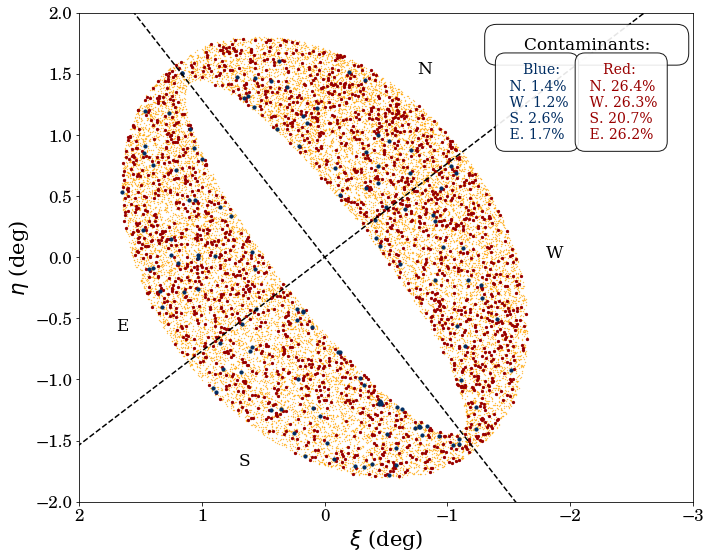

In [37]:
Coord = Lines(37.5) #Calls the function responsible for plotting the lines delemiting the quadrants 

plt.figure(figsize=(11, 9))
plt.scatter((RaDec2[0]), (RaDec2[1]), s=0.1, color='orange')
plt.scatter((RaDec1[0]), (RaDec1[1]), s=0.1, color='orange')
plt.scatter((RaDec3[0]), (RaDec3[1]), s=0.1, color='orange')
plt.scatter((RaDec4[0]), (RaDec4[1]), s=0.1, color='orange')
for i in range(4):
    plt.scatter((AllRedRa[i]), (AllRedDec[i]), s=5, color='#990000')
    plt.scatter((AllBlueRa[i]), (AllBlueDec[i]), s=10, color='#002D62')
plt.plot((Coord[0] - 10.68)*np.cos(39*np.pi/180), (Coord[1] - 41.27), linestyle='--', color='black')
plt.plot((Coord[2] - 10.68)*np.cos(37.5*np.pi/180), (Coord[3] - 41.27), linestyle='--', color='black')
plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.xlim(-3, 2)
plt.ylim(-2, 2)
plt.gca().invert_xaxis()
plt.text(-1.4, 1.7, f'     Contaminants:     ', color='black', 
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.7'), fontname = 'Serif', size = 17)
plt.text(-1.47, 0.97, f'    Blue:\n N. {ContaminantsBlue[1]}%\n W. {ContaminantsBlue[0]}%\n S. {ContaminantsBlue[2]}%\n E. {ContaminantsBlue[3]}%', color='#002D62', 
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.7'), fontname = 'Serif', size = 14)
plt.text(-2.12, 0.97, f'    Red:\n N. {ContaminantsRed[1]}%\n W. {ContaminantsRed[0]}%\n S. {ContaminantsRed[2]}%\n E. {ContaminantsRed[3]}%', color='#990000', 
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.7'), fontname = 'Serif', size = 14)
plt.text(-0.75, 1.5, 'N', fontname = 'Serif', size = 17)
plt.text(-1.8, 0, 'W', fontname = 'Serif', size = 17)
plt.text(0.7, -1.7, 'S', fontname = 'Serif', size = 17)
plt.text(1.7, -0.6, 'E', fontname = 'Serif', size = 17)
plt.savefig('CutsAndAll.png', dpi=500)
plt.show()

### Standard deviation

In [38]:
def StrDev(DATA):
    Mean = np.average(DATA)
    Sum  = 0
    
    for i in range(len(DATA)):
        Sum += (DATA[i] - Mean)**2
        
    return np.sqrt(Sum/len(DATA))

In [39]:
PmRaB  = []
PmDecB = []
PmRaR  = []
PmDecR = []

for i in range(4): 
    PmRaB.append(np.array(QuadrantBlue(evt_data, i)[2]))
    PmDecB.append(np.array(QuadrantBlue(evt_data, i)[3]))
    PmRaR.append(np.array(QuadrantRed(evt_data, i)[2]))
    PmDecR.append(np.array(QuadrantRed(evt_data, i)[3]))

<ipython-input-22-fcba6570fc92>:6: RuntimeWarning: invalid value encountered in greater
  if np.isnan(G[i] > -1.4*(X[i]) + 20.65) == True:
<ipython-input-22-fcba6570fc92>:8: RuntimeWarning: invalid value encountered in greater
  if G[i] > -1.4*(X[i]) + 20.65:


In [40]:
BlueSam = []
RedSam  = []

for i in range(4):
    BlueSam.append(f'({round(StrDev(PmRaB[i]), 4)}, {round(StrDev(PmDecB[i]), 4)})')
    RedSam.append(f'({round(StrDev(PmRaR[i]), 4)}, {round(StrDev(PmDecR[i]), 4)})')

In [41]:
#TableResult = [['Quadrant', 'Blue', 'Red']]
TableResult= [['Quadrant', 'N       ', 'W       ', 'S       ', 'E       ']]
TableResult.append(['Blue            '] + BlueSam)
TableResult.append(['Red             '] + RedSam)
clust_data = np.array(TableResult)
B = clust_data.transpose()
print(B)

[['Quadrant' 'Blue            ' 'Red             ']
 ['N       ' '(1.9748, 1.0095)' '(5.3248, 3.5544)']
 ['W       ' '(1.7492, 0.8919)' '(5.8798, 3.4824)']
 ['S       ' '(0.5982, 0.6578)' '(5.0398, 3.781)']
 ['E       ' '(0.9134, 0.5138)' '(5.0525, 3.3871)']]


## Proper motion limited sample

In [42]:
MeanFiducialRa  = np.average(np.array(evt_data[mask6]['pmra']))
MeanFiducialDec = np.average(np.array(evt_data[mask6]['pmdec']))

def PropMotion(pmra, pmraE, pmdec, pmdecE): 
    Result = []
    PMRA, PMRAe, PMDEC, PMDECe = np.array(pmra), np.array(pmraE), np.array(pmdec), np.array(pmdecE)
    
    for i in range(len(PMRA)):
        if abs(PMRA[i] - MeanFiducialRa) < 0.19 + 3*PMRAe[i]:
            if abs(PMDEC[i] - MeanFiducialDec) < 0.19 + 3*PMDECe[i]:
                Result.append(True)
            else:
                Result.append(False)
        else: 
            Result.append(False)
            
    return Result

In [43]:
Mask = mask6

A = np.array(PropMotion(evt_data[Mask]['pmra'], evt_data[Mask]['pmra_error'], 
                    evt_data[Mask]['pmdec'], evt_data[Mask]['pmdec_error']))

count = 0
for i in range(len(A)):
    if A[i] == False:
        count += 1
        
print(f'The filtered blue sample contains {len(A) - count} which represents {round(100 - count*100/len(A), 2)}% of the initial sample (96.98% in the paper).')

The filtered blue sample contains 1867 which represents 97.14% of the initial sample (96.98% in the paper).


In [44]:
Mask = mask7

A = np.array(PropMotion(evt_data[Mask]['pmra'], evt_data[Mask]['pmra_error'], 
                    evt_data[Mask]['pmdec'], evt_data[Mask]['pmdec_error']))

count = 0
for i in range(len(A)):
    if A[i] == False:
        count += 1
        
print(f'The filtered red sample contains {len(A) - count} which represents {round(100 - count*100/len(A), 2)}% of the initial sample (71.72% in the paper).')

The filtered red sample contains 1543 which represents 71.8% of the initial sample (71.72% in the paper).


## Velocity space

In [45]:
mask8 = (np.isnan(evt_data['parallax']) != True
       ) & ((evt_data['parallax'] - evt_data['parallax_error']) < 0.1
       ) & (evt_data['phot_g_mean_mag'] > 16
       ) & (evt_data['phot_g_mean_mag'] < 20
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) < 0.5
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) > -1
       ) & (np.array(CCorrCond(evt_data['phot_bp_mean_flux'], evt_data['phot_rp_mean_flux'], 
                               evt_data['phot_g_mean_flux'], (evt_data['phot_bp_mean_mag'] - 
                               evt_data['phot_rp_mean_mag']), evt_data['phot_g_mean_mag'])[0]) == False
       ) & (evt_data['ruwe'] < 1.3
       ) & (evt_data['ipd_gof_harmonic_amplitude'] < 0.1
       ) & (evt_data['ipd_frac_multi_peak'] < 2
       ) & (np.array(ElContour(evt_data['ra'], evt_data['dec'])) == True
       ) & (np.array(PropMotion(evt_data['pmra'], evt_data['pmra_error'], 
                    evt_data['pmdec'], evt_data['pmdec_error'])))

mask9 = (np.isnan(evt_data['parallax']) != True
       ) & ((evt_data['parallax'] - evt_data['parallax_error']) < 0.1
       ) & (np.array(RedTopCut(evt_data['phot_g_mean_mag'], (evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']))) == True
       ) & (evt_data['phot_g_mean_mag'] < 20
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) < 4
       ) & ((evt_data['phot_bp_mean_mag'] - evt_data['phot_rp_mean_mag']) > 1.6
       ) & (np.array(CCorrCond(evt_data['phot_bp_mean_flux'], evt_data['phot_rp_mean_flux'], 
                               evt_data['phot_g_mean_flux'], (evt_data['phot_bp_mean_mag'] - 
                               evt_data['phot_rp_mean_mag']), evt_data['phot_g_mean_mag'])[0]) == False
       ) & (evt_data['ruwe'] < 1.3
       ) & (evt_data['ipd_gof_harmonic_amplitude'] < 0.1
       ) & (evt_data['ipd_frac_multi_peak'] < 2
       ) & (np.array(ElContour(evt_data['ra'], evt_data['dec'])) == True
       ) & (np.array(PropMotion(evt_data['pmra'], evt_data['pmra_error'], 
                    evt_data['pmdec'], evt_data['pmdec_error'])))

<ipython-input-22-fcba6570fc92>:6: RuntimeWarning: invalid value encountered in greater
  if np.isnan(G[i] > -1.4*(X[i]) + 20.65) == True:
<ipython-input-22-fcba6570fc92>:8: RuntimeWarning: invalid value encountered in greater
  if G[i] > -1.4*(X[i]) + 20.65:


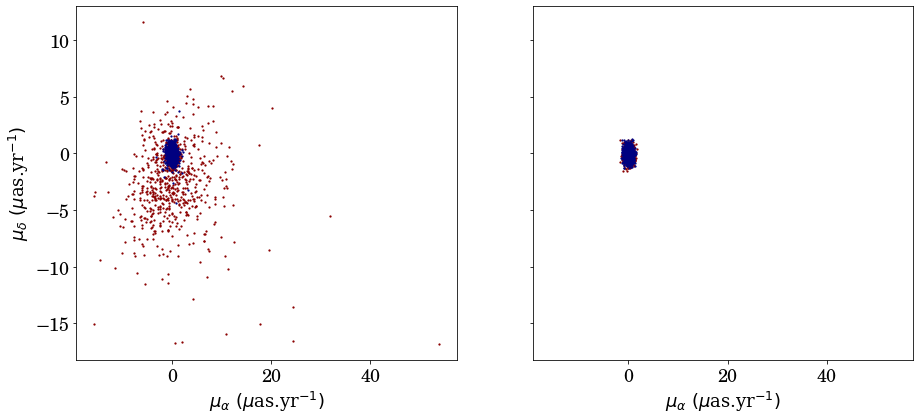

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 6.5))

#pos = ax1.scatter(evt_data[mask5]['pmra'], evt_data[mask5]['pmdec'], s=0.5, color='orange')
pos = ax1.scatter(evt_data[mask7]['pmra'], evt_data[mask7]['pmdec'], s=1.5, color='darkred')
pos = ax1.scatter(evt_data[mask6]['pmra'], evt_data[mask6]['pmdec'], s=1.5, color='navy')
ax1.set_xlabel(r'$\mu_{\alpha}$ $(\mu$as.yr$^{-1})$', fontname = 'Serif', size = 18)
ax1.set_ylabel(r'$\mu_{\delta}$ $(\mu$as.yr$^{-1})$', fontname = 'Serif', size = 18)
ax1.xaxis.set_tick_params(labelsize=18)
ax1.yaxis.set_tick_params(labelsize=18)

#pos = ax2.scatter(evt_data[mask5]['pmra'], evt_data[mask5]['pmdec'], s=0.5, color='orange')
pos = ax2.scatter(evt_data[mask9]['pmra'], evt_data[mask9]['pmdec'], s=1.5, color='darkred')
pos = ax2.scatter(evt_data[mask8]['pmra'], evt_data[mask8]['pmdec'], s=1.5, color='navy')
ax2.set_xlabel(r'$\mu_{\alpha}$ $(\mu$as.yr$^{-1})$', fontname = 'Serif', size = 18)
#ax2.set_ylabel(r'$\mu_{\delta}$ $(\mu$as.yr$^{-1})$', fontname = 'Serif', size = 18)
ax2.xaxis.set_tick_params(labelsize=18)
ax2.yaxis.set_tick_params(labelsize=18)
    
#plt.show()

## Export the data

In [47]:
import csv

def InCVSGaia(name, LIST1, LIST2, LIST3, LIST4, LIST5, LIST6, LIST7):
    with open('ThisIsTheData/' + name + '.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        for i in range(len(LIST1)):
            writer.writerow([LIST1[i], LIST2[i], LIST3[i], LIST4[i], LIST5[i], LIST6[i], LIST7[i]])

In [48]:
InCVSGaia('AllStars',  evt_data[mask5]['ra'], evt_data[mask5]['dec'], evt_data[mask5]['pmra'],
        evt_data[mask5]['pmra_error'], evt_data[mask5]['pmdec'], evt_data[mask5]['pmdec_error'],
        evt_data[mask5]['pmra_pmdec_corr'])

InCVSGaia('BlueStars', evt_data[mask8]['ra'], evt_data[mask8]['dec'], evt_data[mask8]['pmra'],
        evt_data[mask8]['pmra_error'], evt_data[mask8]['pmdec'], evt_data[mask8]['pmdec_error'],
        evt_data[mask8]['pmra_pmdec_corr'])

InCVSGaia('RedStars',  evt_data[mask9]['ra'], evt_data[mask9]['dec'], evt_data[mask9]['pmra'],
        evt_data[mask9]['pmra_error'], evt_data[mask9]['pmdec'], evt_data[mask9]['pmdec_error'],
        evt_data[mask9]['pmra_pmdec_corr'])